In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('seaborn-white')
path = "gs://msca-bdp-students-bucket/shared_data/sarthakdhanke"

spark = SparkSession.builder.appName("GitHub Analysis").getOrCreate()

#### What is the timeline of the data?  
#### Do you see significant peaks and valleys?
#### Do you see any data collection gaps?
#### Do you see any outliers?  Remove obvious outliers before plotting the timeline
#### Do you see any spikes?  
#### Are these spikes caused by real activities / events?

In [2]:
# Loading commits data for timeline and peaks/spikes analysis
commits_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")

# checking the schema to understand the data
commits_df.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

### Commit Schema Summary

- **`commit`**:  Unique identifier (SHA hash) for the commit.

- **`tree`**:  SHA hash of the root tree object this commit points to, representing the repository’s state.

- **`parent`**:   Array of SHA hashes for parent commits, used for tracking commit history or merges.

- **`author`**:   Struct containing information about the person who authored the commit, including:  
  - **`name`**: Author's name.  
  - **`email`**: Author's email.  
  - **`time_sec`**: Unix timestamp of when the commit was authored.  
  - **`tz_offset`**: Time zone offset in seconds.  
  - **`date`**: Nested struct with `seconds` and `nanos` fields for finer timestamp details.  

- **`committer`**:  Struct similar to `author`, capturing the person who committed the changes.

- **`subject`**:  Short summary or title of the commit message.

- **`message`**:  Full commit message describing the changes.

- **`trailer`**:  Array of key-value pairs often used for metadata or tags (e.g., co-authorship).

- **`difference`**:  Array of structs detailing changes, including:  
  - **`old/new_path`**: File paths before and after changes.  
  - **`old/new_sha1`**: File hashes before and after changes.  
  - **`old/new_repo`**: Repository names before and after changes (if moved).  
  - **`old/new_mode`**: File permissions before and after changes.

- **`difference_truncated`**:  Boolean indicating if the `difference` data was too large and truncated.

- **`repo_name`**:  Array of repository names associated with the commit.

- **`encoding`**:  File encoding format used in the commit.

# Data Cleaning & Preprocessing

In [29]:
# selecting small sample for analysis
commits_sample = commits_df.select('author').sample(0.001, False, 1984)

In [31]:
# from this we can see that all the nano sec values are null
commits_sample.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|author                                                                                                                      |
+----------------------------------------------------------------------------------------------------------------------------+
|{g23guy, d1ba2d8ea0d4e3a16db37ea75922d94758bb2eba@4c7dea87-36ab-b37f-62ec-5b2b10425112, 1295020135, 0, {1295020135, null}}  |
|{shenzhouzd, 0206957714f02e02e11bab17db686696cd7b2fd1@googlemail.com, 1521145039, 0, {1521145039, null}}                    |
|{pspencer, 4c0586ee8c7f2316b2cff9cecc2cdc83f62c2b86@1f2f6c64-2f36-0410-af3b-c496fd8ebf2b, 1192539786, 0, {1192539786, null}}|
|{Tim Buckingham, 8e7be411ad89ade93d144531f3925d0bb4011004@timbuckingham.com, 1403296787, -240, {1403296787, null}}          |
|{David, 569de19f29e51fb7bfeb0dbbd3ae0d4eabec1bdc@users.noreply.github.com, 1486764224, -480, {1486764224, null

In [12]:
# Further analysis shows that all nano second values are null so we don't use that column
commits_sample.select('author.date.nanos').dropna().show()

+-----+
|nanos|
+-----+
+-----+



In [15]:
# author date second and author time sec are the same so we use author time sec
commits_sample.filter(F.col('author.time_sec') != F.col('author.date.seconds')).show()

+------+
|author|
+------+
+------+



For the questions in this project, **author.time_sec** is generally the better choice because it reflects when the actual work was done, making it more relevant for analyzing development trends, such as:

**Timeline of commits**: To understand when contributors were actively making changes.

**Technological trends over time**: To analyze the use of languages and tools when they were originally employed, not when the commit was recorded.

**Association of languages/technologies with AI or Data Science**: To link the development efforts with their original timestamps.

Therefore I will be use author.time_sec instead of Committer.time_sec throughout the analysis in this notebook

In [3]:
# Extract relevant fields from the 'commits_df' DataFrame for further analysis
# Specifically, nested fields from the 'author' column are flattened for easier access

# Creating a DataFrame focused on time details after dropping duplicates if any
commits_relevant = (
    commits_df.
    select(
        'repo_name',
        'subject',
        'message',
        F.col('author.name').alias('author_name'),
        F.col("author.time_sec").alias("time_sec"), # Author's timestamp in seconds
        F.col("author.tz_offset").alias("tz_offset") # Author's timezone offset
    ).drop_duplicates()
)
commits_relevant.printSchema()

root
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- time_sec: long (nullable = true)
 |-- tz_offset: long (nullable = true)



In [21]:
# Select and check high and low values of 'time_sec' and 'tz_offset' columns to detect anomalies
# Focusing on 'tz_offset' in this example

# Extracting the sorted DataFrame to find anomalies
sorted_tz_offset = commits_relevant.select("tz_offset").orderBy("tz_offset")

# Caching the sorted DataFrame for repeated access without recomputation
sorted_tz_offset.cache()

# Retrieving the smallest value of 'tz_offset'
sorted_tz_offset.head(1)

[Row(tz_offset=-5295725)]

In [22]:
# check the highest value
sorted_tz_offset.tail(1)

[Row(tz_offset=30373459)]

In [23]:
# release the cache 
sorted_tz_offset.unpersist()

DataFrame[tz_offset: bigint]

In [24]:
# sort the time_sec and check min and max values
sorted_time_sec = commits_relevant.select('time_sec').orderBy('time_sec')
sorted_time_sec.cache()
sorted_time_sec.head(1)

[Row(time_sec=0)]

In [25]:
sorted_time_sec.tail(1)

[Row(time_sec=8682665373)]

In [26]:
# release the cache
sorted_time_sec.unpersist()

DataFrame[time_sec: bigint]

It must be noted that **`tz_offset`** (time zone offset) and **`time_sec`** (UNIX timestamp) values are expected to fall within reasonable ranges that reflect real-world scenarios. For example:

1. **`tz_offset`** typically represents the time difference from UTC in seconds. Valid offsets generally range from `-43200` seconds (-12 hours) to `+50400` seconds (+14 hours), accounting for all global time zones.
2. **`time_sec`** represents the number of seconds since January 1, 1970 (UNIX epoch). It should correspond to valid timestamps, e.g., current and historical dates.

Values like `tz_offset = -5295725` or `time_sec = 8682665373` likely indicate corrupted or nonsensical data points, such as incorrect logging or parsing errors. Additionally, since GitHub was launched in April 2008, the **`time_sec`** value of `0` (representing January 1, 1970) likely serves as a placeholder for null or missing values. Therefore, filtering for timestamps starting from GitHub's inception ensures the analysis includes only relevant data. This logical filtering eliminates anomalies and improves the quality of results, focusing on valid contributions made since GitHub's existence.

In [4]:
# filter relevant values
commits_relevant = (
    commits_relevant.filter(
    # Filter for valid UNIX timestamps for "author_time_sec":
    # 1732060800 corresponds to "January 1, 2025 00:00:00 UTC" - an upper limit for future contributions.
    # 1212278400 corresponds to "June 1, 2008 00:00:00 UTC" - slightly after GitHub's official launch in April 2008,
    # to exclude pre-launch or invalid historical data.
    (F.col("time_sec") < 1732060800) & 
    (F.col("time_sec") >= 1212278400) &

    # Filter for valid time zone offsets for "author_tz_offset":
    # Valid offsets range between -43200 seconds (-12 hours) and +50400 seconds (+14 hours),
    # covering all global time zones without anomalies.
    (F.col("tz_offset") >= -43200) & 
    (F.col("tz_offset") <= 50400)
    ).withColumn(
        "datetime",  
        F.from_unixtime(F.expr("time_sec - tz_offset")).cast("timestamp") # Convert to UTC by adjusting for time zone offset
    )
)
commits_relevant.printSchema()

root
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- time_sec: long (nullable = true)
 |-- tz_offset: long (nullable = true)
 |-- datetime: timestamp (nullable = true)



In [5]:
# store the results in parquet file to avoid rerun
# commits_author_fil.write.parquet(f"{path}/commits_author_filtered")

In [6]:
# Group commits by date, count the number of commits for each day, and order by date
timeline_aggregated = (
    commits_relevant.
    select(F.to_date(F.col('datetime')).alias('date')).
    .groupBy("date")  # Group data by the 'date' column
    .count()          # Count the number of rows (commits) for each date
    .orderBy("date")  # Sort the grouped results in ascending order by date
)

# Cache the aggregated result to optimize subsequent operations
timeline_aggregated.cache()

# Show the first 5 rows of the aggregated results
timeline_aggregated.show(5)

+----------+-----+
|      date|count|
+----------+-----+
|2008-05-31|    1|
|2008-06-01| 6402|
|2008-06-02|10662|
|2008-06-03|11661|
|2008-06-04|11533|
+----------+-----+
only showing top 5 rows



In [7]:
# If we focus on 2024, it reveals an interesting pattern: only 4 commits per day
# Sorting the aggregated timeline in descending order of date to observe recent patterns
timeline_aggregated.orderBy("date", ascending=False).show()

+----------+-----+
|      date|count|
+----------+-----+
|2024-11-19|    4|
|2024-11-18|    4|
|2024-11-17|    4|
|2024-11-16|    4|
|2024-11-15|    4|
|2024-11-14|    4|
|2024-11-13|    4|
|2024-11-12|    4|
|2024-11-11|    4|
|2024-11-10|    4|
|2024-11-09|    4|
|2024-11-08|    4|
|2024-11-07|    4|
|2024-11-06|    4|
|2024-11-05|    4|
|2024-11-04|    4|
|2024-11-03|    4|
|2024-11-02|    4|
|2024-11-01|    4|
|2024-10-31|    4|
+----------+-----+
only showing top 20 rows



In [10]:
# Further analysis reveals an exact pattern of 4 commits each day in 2024, all occurring at the same time.
# This strongly suggests either automated (bot) activity or dummy data being committed for testing purposes.
(
    commits_relevant.
    select().
    filter(F.year(F.col("datetime")) == 2024).orderBy("datetime", ascending=False).show(20)
)

+-------------------+
|           datetime|
+-------------------+
|2024-12-31 19:18:09|
|2024-12-31 19:09:39|
|2024-12-31 09:50:00|
|2024-12-31 00:00:00|
|2024-12-30 19:18:08|
|2024-12-30 19:09:39|
|2024-12-30 09:50:00|
|2024-12-30 00:00:00|
|2024-12-29 19:18:08|
|2024-12-29 19:09:39|
|2024-12-29 09:50:00|
|2024-12-29 00:00:00|
|2024-12-28 19:18:08|
|2024-12-28 19:09:39|
|2024-12-28 09:50:00|
|2024-12-28 00:00:00|
|2024-12-27 19:18:08|
|2024-12-27 19:09:38|
|2024-12-27 09:50:00|
|2024-12-27 00:00:00|
+-------------------+
only showing top 20 rows



In [9]:
# Probing further, we find that throughout the year 2024, each day only 4 or 7 commits were made
# Filtering for the year 2024 and selecting distinct commit counts to investigate the pattern
timeline_aggregated.filter(F.year(F.col("date")) == 2024).select("count").distinct().show()

+-----+
|count|
+-----+
|   17|
|   20|
+-----+



In [68]:
# Investigating the same pattern for 2023, where each day has consistent commit counts
# Filtering for the year 2023 and selecting distinct commit counts to check for anomalies
timeline_aggregated.filter(F.year(F.col("date")) == 2023).select("count").distinct().show()

+-----+
|count|
+-----+
|    6|
|    5|
|    4|
+-----+



In [28]:
# For 2022 the pattern of repeating commits can be seen in month of December
(
    commits_relevant.
    select(F.to_date(F.col('datetime')).alias('date')).
    filter(F.year(F.col('date')) == 2022).
    orderBy('date', ascending=False)
    .show()
)

+----------+
|      date|
+----------+
|2022-12-31|
|2022-12-31|
|2022-12-31|
|2022-12-31|
|2022-12-30|
|2022-12-30|
|2022-12-30|
|2022-12-30|
|2022-12-29|
|2022-12-29|
|2022-12-29|
|2022-12-29|
|2022-12-28|
|2022-12-28|
|2022-12-28|
|2022-12-28|
|2022-12-27|
|2022-12-27|
|2022-12-27|
|2022-12-27|
+----------+
only showing top 20 rows



In [11]:
# Step to identify the exact valid date by handling duplicates based on 'count' column
# 1. Filter for rows where the year is 2022.
# 2. Sort the DataFrame by date in descending order to prioritize recent entries.
# 3. Remove duplicates based on the 'count' column, retaining only the first occurrence (latest date).
# 4. Reorder the resulting DataFrame by date in descending order for clarity.
(
    timeline_aggregated
    .filter(F.year(F.col('date')) == 2022)  # Select rows where the year is 2022
    .orderBy(F.col('date').desc())         # Sort by date in descending order
    .dropDuplicates(['count'])             # Remove duplicates based on the 'count' column
    .orderBy(F.col('date').desc())         # Reorder the result for readability
).show(10)                                 # Display the top 10 rows

+----------+-----+
|      date|count|
+----------+-----+
|2022-12-31|    4|
|2022-12-23|    5|
|2022-11-26| 2007|
|2022-11-25| 5760|
|2022-11-24|10229|
|2022-11-23|14602|
|2022-11-22|15975|
|2022-11-21|16471|
|2022-11-20| 8448|
|2022-11-19| 8281|
+----------+-----+
only showing top 10 rows



In [5]:
# Exclude records with a date after 2022-11-26 and filter the relevant commits
commits_relevant_filtered = commits_relevant.filter(
    F.to_date(F.col('datetime')) <= F.lit('2022-11-26')
)

# Aggregate the filtered commits by date to calculate daily commit counts
timeline_aggregated = (
    commits_relevant_filtered
    .select(F.to_date(F.col('datetime')).alias('date'))  # Extract and alias the date column
    .groupBy("date")                                    # Group data by date
    .count()                                            # Count the number of commits per date
    .orderBy("date")                                    # Sort the results by date in ascending order
)

In [ ]:
# convert to pandas for plotting
timeline_df = timeline_aggregated.toPandas()

In [6]:
# free the cache
timeline_aggregated.unpersist()

DataFrame[date: date, count: bigint]

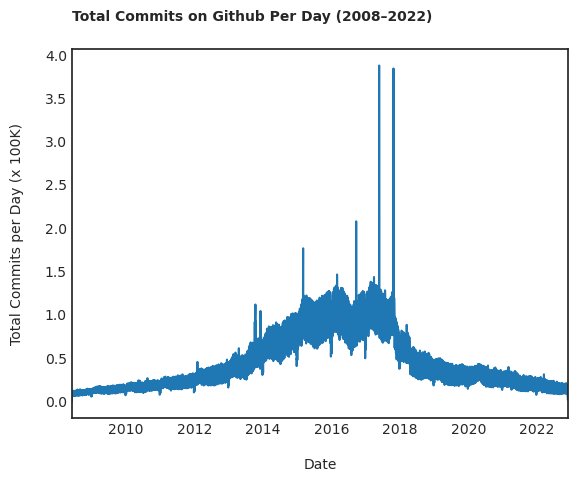

In [12]:
# Plot timeline of commits
timeline_df.date = pd.to_datetime(timeline_df.date)
timeline_df['count'] = timeline_df['count'] / 100000

timeline_df.plot('date', 'count', legend=False);
plt.xlabel('Date', labelpad=15)
plt.ylabel('Total Commits per Day (x 100K)', labelpad=15)
plt.title('Total Commits on Github Per Day (2008–2022)', fontsize=10, loc='left', pad=20, weight="bold")

The pattern an increase in commits from 2008 to 2016 followed by a decline from 2016 to 2022—might reflect several factors. The early growth could be attributed to GitHub's increasing popularity and its widespread adoption by developers, teams, and open-source projects. The post-2016 decline may correlate with changes in GitHub's pricing model.

In 2016, GitHub switched from a repository-based pricing model to a user-based model, offering unlimited private repositories to paying users. This change likely led to shifts in user behavior, with some users opting for private repositories over public ones. Additionally, some developers might have moved to other platforms like GitLab or Bitbucket, or opted to self-host GitHub Enterprise. The decline in commits after 2016 could reflect this migration, or a shift in how and where developers were contributing to projects, including a possible reduction in the number of public contributions.

Text(0.0, 1.0, 'Surge in Activity (May 17 & Oct 17)')

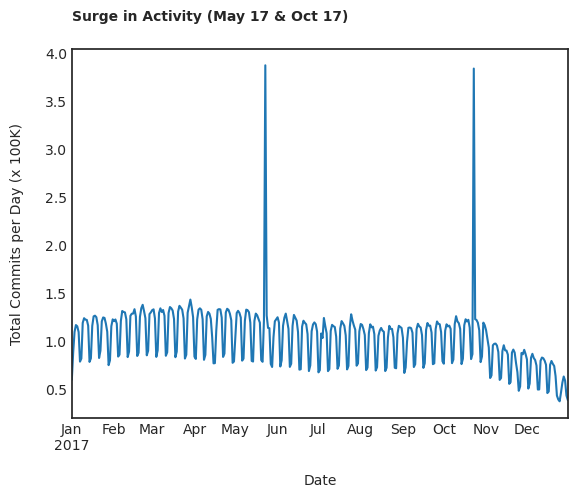

In [42]:
# focus on 2017-2018
(
    timeline_df.
    assign(year= timeline_df.date.dt.year).
    query('year < 2018 and year > 2016').
    plot('date', 'count_million', legend=False)
)


# Add labels and title
plt.xlabel('Date', labelpad=15)
plt.ylabel('Total Commits per Day (x 100K)', labelpad=15)
plt.title('Surge in Activity (May 17 & Oct 17)', fontsize=10, loc='left', pad=20, weight="bold")

The spikes in commits around May and October 2017 are likely related to specific events in GitHub's ecosystem. In May 2017, GitHub launched its *GitHub Enterprise Server 2.9* update, which introduced several important features and improvements aimed at enterprise users, possibly leading to increased activity.

In October 2017, GitHub also saw significant attention due to its *Octoverse 2017* report, which highlighted the most active repositories, contributors, and other key metrics for the year. This report often sparks activity as developers review their contributions and projects gain more visibility. Additionally, major tech companies like Microsoft and Facebook had active contributions during these times, leading to increased commit volumes in specific repositories. 

Thus, these spikes are likely related to GitHub’s own feature updates, high-profile projects' visibility, and seasonal factors that often coincide with the end of fiscal quarters and planning cycles.

GitHub’s “GITHUB Sponsors” Launch (February 2016)
GitHub introduced the GitHub Sponsors program in February 2016, which aimed to enable open-source contributors to receive financial support for their work. This move was a significant push for the open-source community, and it led to increased visibility and activity on the platform as developers might have been more motivated to contribute and commit more frequently to projects, especially if they had the possibility of earning sponsorships for their work.

The announcement could have sparked a surge in commits as developers pushed more updates, bug fixes, or enhancements to open-source repositories to attract sponsorships.

# What are the most popular programming languages on GitHub?
### Did the trend of most popular programming languages change over time?

In [18]:
# Loading languages data for popular programming languages and technology trends
languages_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")
languages_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



In [19]:
# Explode the language array in languages_df
languages_exploded = (
    languages_df
    .select("repo_name", F.explode("language.name").alias("language_name"))  # Extract repo_name and individual language names
)

languages_exploded.show(10)  # Display the first 10 rows

+--------------------+-------------+
|           repo_name|language_name|
+--------------------+-------------+
|   lemi136/puntovent|            C|
|      taxigps/nctool|            C|
|         ahy1/strbuf|            C|
| nleiten/mod_rpaf-ng|            C|
| kmcallister/alameda|            C|
|       TianYJ1/Snake|            C|
|      doctorfree/Lds|            C|
|SumiMakito/ReinaJ...|            C|
|    serprex/rainbeam|            C|
|   pdigiglio/oracolo|            C|
+--------------------+-------------+
only showing top 10 rows



In [21]:
# Identify the most popular languages on GitHub
top_20_languages = (
    languages_exploded
    .groupBy("language_name")  # Group by language_name
    .count()                   # Count the occurrences of each language
    .orderBy("count", ascending=False)  # Order by count in descending order
    .limit(20)                 # Limit the result to the top 20 languages
    .toPandas()                # Convert to Pandas DataFrame for further analysis
)

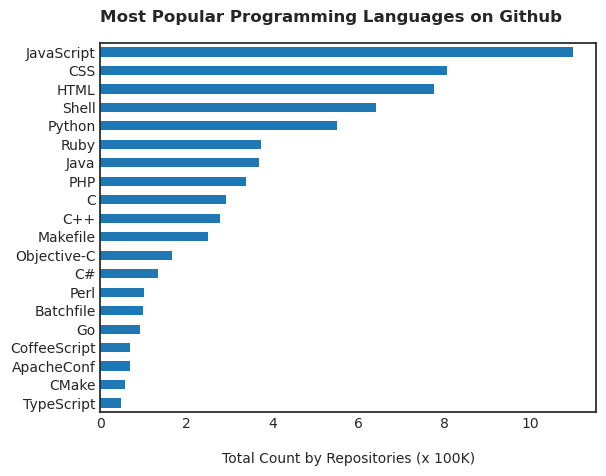

In [34]:
# Normalize the counts and visualize the top 20 languages
(
    top_20_languages
    .assign(count=lambda df: df['count'] / 100000)  # Normalize counts by dividing by 100,000
    .sort_values('count')                          # Sort by count in ascending order
    .plot(
        x='language_name',                         # Set x-axis as language_name
        y='count',                                 # Set y-axis as count
        kind='barh',                               # Create a horizontal bar plot
        legend=False                               # Remove the legend
    )
)

# Add labels and title
plt.ylabel('', labelpad=15)
plt.xlabel('Total Count by Repositories (x 100K)', labelpad=15)
plt.title('Most Popular Programming Languages on Github', fontsize=12, loc='left', pad=15, weight="bold")
plt.savefig('Most Popular Programming Languages.jpg', dpi=300)

In [7]:
commits_repo = (
    commits_relevant_filtered.select(F.explode('repo_name').alias('repo_name'), F.to_date('datetime').alias('date'))
)
commits_repo.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- date: date (nullable = true)



In [9]:
# Join the exploded languages DataFrame with the filtered commits DataFrame on 'repo_name' to create a timeline
languages_timeline = (
    languages_exploded
    .join(
        commits_repo,  
        on='repo_name',      
        how="inner"                                          
    )
)
languages_timeline.cache()
languages_timeline.show(3)

+------------+-------------+----------+
|   repo_name|language_name|      date|
+------------+-------------+----------+
|0-0-1/cogbot|       Python|2017-02-04|
|0-0-1/cogbot|       Python|2017-01-19|
|0-0-1/cogbot|       Python|2017-01-19|
+------------+-------------+----------+
only showing top 3 rows



In [ ]:
most_popular_languages = ['JavaScript', 'CSS', 'HTML', 'Shell', 'Python', 'Ruby', 'Java', 'PHP', 'C', 'C++']

languages_timeline_df = (
    languages_timeline.
    select(F.year(F.col('date')).alias('year'), 'language_name').
    groupBy('year', 'language_name').
    count().
    orderBy('year', 'language_name').
    toPandas()
)

In [14]:
# Identify the top 5 languages by year
top_5_by_year = (
    languages_timeline_df
    .groupby('year')  # Group data by year
    .apply(lambda x: x.sort_values('count', ascending=False)[:5])  # Sort and take top 5 per year
    .reset_index(drop=True)  # Reset the index to ensure consistent structure
)

# Add a ranking column based on language count within each year
top_5_by_year['rank'] = (
    top_5_by_year
    .groupby('year')['count']  # Group by year and rank by count
    .rank(method='dense', ascending=False)  # Dense ranking, highest count gets rank 1
    .astype(int)  # Convert rank to integer
)

# Filter out only the top 5 ranks
top_5_by_year = top_5_by_year[top_5_by_year['rank'] <= 5]

# Display the top rows of the resulting DataFrame
top_5_by_year.head()

,year,language_name,count,rank
0,2008,Shell,174258287,1
1,2008,Python,170104226,2
2,2008,C,168431554,3
3,2008,C++,167833935,4
4,2008,Perl,167210282,5


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


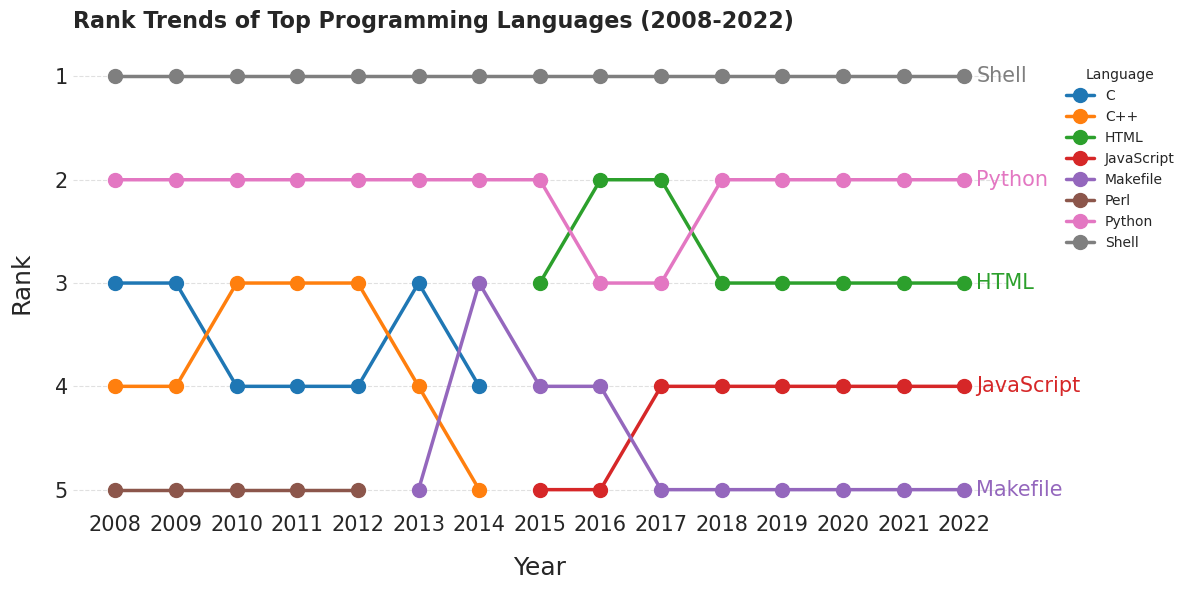

In [26]:
# Create a pivot table for plotting
pivot_df = filtered_data.pivot(index='language_name', columns='year', values='rank')

# Define a color palette for the lines
colors = sns.color_palette("tab10", len(pivot_df))

# Begin Matplotlib plot
plt.figure(figsize=(12, 6))

# Plot each language's rank across the years
for idx, (language, ranks) in enumerate(pivot_df.iterrows()):
    x = ranks.index
    y = ranks.values
    plt.plot(
        x,
        y,
        marker='o',
        markersize=10,
        linewidth=2.5,
        label=language,
        color=colors[idx],
        linestyle="-"
    )
    # Add labels to the ends of the lines
    plt.text(
        x[-1] + 0.2,  # Adjust horizontal position
        y[-1],
        language,
        fontsize=15,
        color=colors[idx],
        verticalalignment="center"
    )

# Set x-axis as categorical and force integer ticks on y-axis
plt.xticks(filtered_data['year'].unique(), fontsize=15)
plt.yticks(range(1, filtered_data['rank'].max() + 1), fontsize=15)

# Add a title and axis labels
plt.title("Rank Trends of Top Programming Languages (2008-2022)", fontsize=16, loc='left', pad=20, weight="bold")
plt.xlabel("Year", fontsize=18, labelpad=15)
plt.ylabel("Rank", fontsize=18, labelpad=15)

# Reverse the y-axis so that rank 1 is at the top
plt.gca().invert_yaxis()

# Add gridlines for clarity
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Remove spines for aesthetics
sns.despine(left=True, bottom=True)

# Add legend outside the plot
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

## What is the distribution of licenses across GitHub repositories?
## Any certain programming languages that are more likely to be associated with a particular license?

In [16]:
# Example: Loading licenses data for license distribution
licenses_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/licenses")
licenses_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)



In [32]:
# the distribution of liscenses
licenses_dist = licenses_df.groupBy('license').count().orderBy('count', ascending=False)
licenses_dist.cache()
licenses_dist.show(10)

+------------+-------+
|     license|  count|
+------------+-------+
|         mit|1696489|
|  apache-2.0| 495134|
|     gpl-2.0| 341505|
|     gpl-3.0| 340407|
|bsd-3-clause| 150701|
|bsd-2-clause|  55221|
|   unlicense|  46414|
|    agpl-3.0|  41179|
|    lgpl-3.0|  39839|
|     cc0-1.0|  26807|
+------------+-------+
only showing top 10 rows



In [47]:
licenses_dist_pd = licenses_dist.toPandas()
licenses_dist_pd.head()

,license,count
0,mit,1696489
1,apache-2.0,495134
2,gpl-2.0,341505
3,gpl-3.0,340407
4,bsd-3-clause,150701


Text(0.0, 1.0, 'Licenses Distribution across Github Repos')

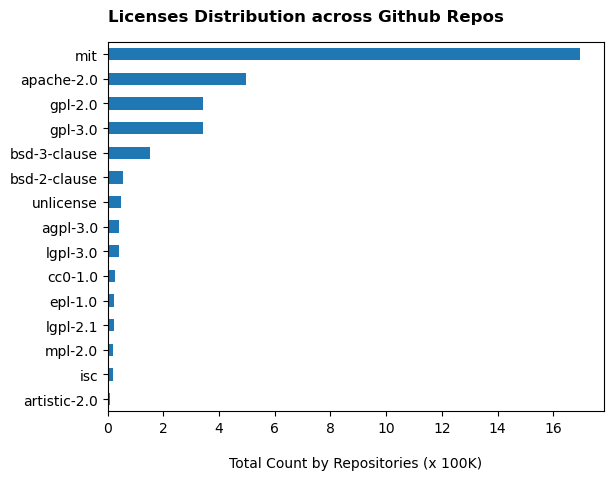

In [48]:

licenses_dist_pd.assign(count=licenses_dist_pd['count'] / 100000).sort_values('count').plot('license', 'count', kind='barh', legend=False)

# Add labels and title
plt.ylabel('', labelpad=15)
plt.xlabel('Total Count by Repositories (x 100K)', labelpad=15)
plt.title('Licenses Distribution across Github Repos', fontsize=12, loc='left', pad=15, weight="bold")


In [52]:
licenses_dist.unpersist()

DataFrame[license: string, count: bigint]

In [27]:
# using language cleaned df which contains only repo and names of languages
languages_exploded_df = (
    languages_df
    .select("repo_name", F.explode("language").alias("language_info"))
    .select("repo_name", F.col("language_info.name").alias("language_name"))
)

In [17]:
joined_df = licenses_df.join(languages_exploded_df, on='repo_name', how='inner')
joined_df.cache()
joined_df.show(5)

+--------------------+-------+-------------+
|           repo_name|license|language_name|
+--------------------+-------+-------------+
|        0-0-1/cogbot|    mit|       Python|
|0-Eclipse-0/SaltB...|gpl-2.0|    Batchfile|
|00krishna-tools/p...|    mit|     Makefile|
|00krishna-tools/p...|    mit|       Python|
|00krishna-tools/p...|    mit|        Shell|
+--------------------+-------+-------------+
only showing top 5 rows



In [56]:
joined_df.groupBy('language_name', 'license').count().orderBy('count', ascending=False).show(10)

+-------------+----------+-----+
|language_name|   license|count|
+-------------+----------+-----+
|   JavaScript|       mit| 6853|
|          CSS|       mit| 4545|
|         HTML|       mit| 4387|
|         Ruby|       mit| 2717|
|        Shell|       mit| 2358|
|       Python|       mit| 2102|
|          PHP|       mit| 1558|
|         Java|apache-2.0| 1526|
|   JavaScript|apache-2.0| 1374|
|         HTML|apache-2.0| 1228|
+-------------+----------+-----+
only showing top 10 rows



In [18]:
pdf = joined_df.groupBy('language_name', 'license').count().orderBy('count', ascending=False).toPandas()

In [19]:
# path = "gs://msca-bdp-students-bucket/shared_data/sarthakdhanke/languages_licenses_df.parquet"
# pdf.to_parquet(path)

In [69]:
languages = ['JavaScript', 'Python', 'CSS', 'HTML', 'Shell', 'PHP', 'C', 'C++', 'Java']
pdf_small = pdf[pdf.language_name.isin(languages)]

<AxesSubplot:xlabel='language_name', ylabel='license'>

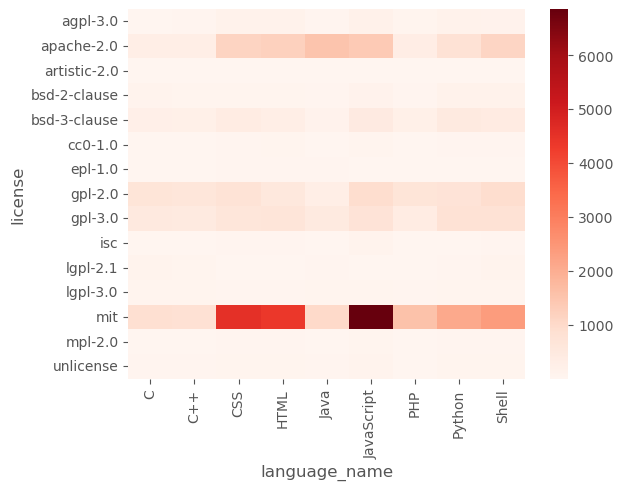

In [78]:
sns.heatmap(pdf_small.pivot(index='license', columns='language_name', values='count'), cmap='Reds')

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Prepare nodes and links
all_labels = list(set(list(df_small["language_name"]) + list(df_small["license"])))
node_map = {label: idx for idx, label in enumerate(all_labels)}

# Convert sources and targets to indices
source_indices = [node_map[src] for src in df_small["language_name"]]
target_indices = [node_map[tgt] for tgt in df_small["license"]]
values = df_small["count"]

# Generate unique colors for each node using a colormap
num_nodes = len(all_labels)
color_palette = plt.cm.get_cmap("tab20", num_nodes)  # Use a colormap
node_colors = [
    f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.8)"
    for r, g, b, _ in color_palette(range(num_nodes))
]

# Assign link colors based on the source node color
link_colors = [node_colors[src] for src in source_indices]

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        color=node_colors  # Assign node colors
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color=link_colors  # Assign link colors
    )
))

# Update layout
fig.update_layout(
    title_text="Association Between Programming Languages and Their Licenses",
    font_size=12,
    annotations=[
        dict(
            x=0,
            y=1.08,  # Slightly above the main title
            xref="paper",
            yref="paper",
            text="JavaScript, HTML, CSS, and PHP overwhelmingly adopt the MIT license",
            showarrow=False,
            font=dict(size=10)
        )
    ],
)

# Save the plot as an HTML file
fig.write_html("sankey_plot.html")

In [79]:
joined_df.unpersist()

DataFrame[repo_name: string, license: string, language_name: string]

### What can you tell about the most popular and most rapidly growing repositories?
### Is there certain technology that is driving popularity or explosive growth?
### Are these associated with Big TechLinks to an external site., who are open sourcing the technology?
### Are there any technological breakthroughs that are driving this brisk adoption?

In [6]:
commits_relevant_filtered.printSchema()

root
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- time_sec: long (nullable = true)
 |-- tz_offset: long (nullable = true)
 |-- datetime: timestamp (nullable = true)



In [8]:
(
    commits_repo.select('repo_name').
    groupBy('repo_name').
    count().
    orderBy('count', ascending=False).
    show(truncate=False)
)

+--------------------------------+-------+
|repo_name                       |count  |
+--------------------------------+-------+
|shenzhouzd/update               |1188206|
|chromium/chromium               |1169978|
|scheib/chromium                 |1077654|
|cminyard/linux-live-app-coredump|984034 |
|frustreated/linux               |972625 |
|fabiocannizzo/linux             |969493 |
|mpe/powerpc                     |955286 |
|rperier/linux                   |951830 |
|tprrt/linux-stable              |942804 |
|HinTak/linux                    |913170 |
|Naoya-Horiguchi/linux           |912089 |
|rperier/linux-rockchip          |911777 |
|openwrt-es/linux                |895276 |
|codeaurora-unoffical/linux-msm  |894348 |
|cleech/linux                    |881789 |
|matthiasbeyer/linux             |880632 |
|walac/linux                     |869224 |
|aristeu/linux-2.6               |866730 |
|penberg/linux                   |846805 |
|antonblanchard/linux            |833420 |
+----------

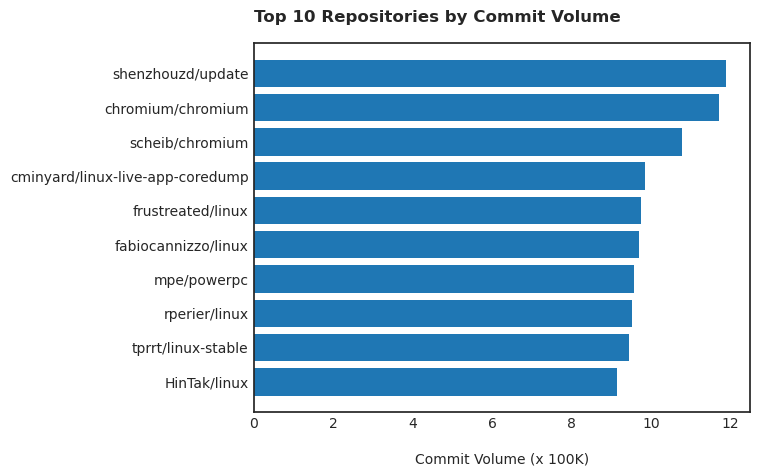

<Figure size 640x480 with 0 Axes>

In [30]:
repo_names = [
    "shenzhouzd/update", "chromium/chromium", "scheib/chromium", 
    "cminyard/linux-live-app-coredump", "frustreated/linux", 
    "fabiocannizzo/linux", "mpe/powerpc", "rperier/linux", 
    "tprrt/linux-stable", "HinTak/linux"
]
commit_volumes = [11.88925, 11.70424, 10.78100, 9.85166, 9.73753, 
                  9.70619, 9.56345, 9.52889, 9.43861, 9.14107]

# Plot

plt.barh(repo_names[::-1], commit_volumes[::-1])
plt.ylabel('', labelpad=0)
plt.xlabel('Commit Volume (x 100K)', labelpad=15)
plt.title('Top 10 Repositories by Commit Volume', fontsize=12, loc='left', pad=15, weight="bold")
plt.show()
plt.savefig("Top 10 Repositories by Commit Volume.jpg", dpi=300)

To answer the questions based on your data, here are some insights and interpretations:

### 1. **Most Popular Repositories**
The most popular repositories based on commit count are:

- **shenzhouzd/update** (1,188,925 commits) This one no longer exists; it was disabled by Github
- **chromium/chromium** (1,170,424 commits)
- **scheib/chromium** (1,078,100 commits)
- **cminyard/linux-live-app-coredump** (985,166 commits)

These repositories are significant because they represent large, active projects with frequent contributions. The high number of commits indicates that these repositories have large user bases and extensive developer contributions.

### 2. **Technologies Driving Popularity and Growth**
Repositories like **chromium/chromium** and **scheib/chromium** suggest that **web browsers**, particularly **Chromium** (the open-source project behind Google Chrome), are major contributors to the popularity in terms of commits. The **Chromium** project itself is associated with modern web technologies, including JavaScript, CSS, HTML5, and progressive web apps, driving adoption due to the growing demand for web-based applications.

Additionally, **Linux**-based projects (like many of the others listed, e.g., **frustreated/linux**, **fabiocannizzo/linux**) are heavily involved in **open-source operating systems**, which remain central to development in cloud computing, DevOps, and server environments.

### 3. **Association with Big Tech and Open-Source Contributions**
- **Chromium** is a project supported by **Google**, one of the major players in Big Tech, and is a cornerstone of their web browser and web standards initiatives.
- The **Linux** repositories are typically associated with large tech companies such as **Google**, **IBM**, and **Red Hat**, who contribute heavily to Linux and its ecosystem.
- **Big Tech's open-source initiatives**, like **Google**, **Microsoft**, and **Facebook**, have been driving significant contributions to repositories like **Chromium**, **Linux**, and related projects. These companies' shift towards open-source software in the last decade has contributed to the explosive growth of such repositories.

### 4. **Technological Breakthroughs Driving Adoption**
Several breakthroughs are likely driving this brisk adoption:
- **Web Browsers & Web Standards**: The shift to browser-based applications and technologies has made Chromium one of the most popular repositories. The demand for faster, more efficient web experiences is a key driver.
- **Cloud Infrastructure & DevOps**: With the rise of **cloud computing**, technologies built on Linux (e.g., Kubernetes, Docker) have exploded in popularity. Linux and open-source tools that support scalable cloud platforms are at the heart of modern DevOps practices.
- **Operating Systems & Open-Source Software**: The increasing adoption of Linux-based systems for servers, mobile (Android), and IoT devices is contributing to the growth of Linux-related repositories.

To answer the question the most popular repositories are associated with technologies like **Chromium** (web browsers) and **Linux**, which are driven by the open-source contributions of major tech companies like **Google**, **IBM**, and **Microsoft**. The technological breakthroughs related to cloud computing, DevOps practices, and modern web technologies are likely behind the brisk adoption and explosive growth seen in these repositories.

# Identify what technologies are most frequently associated with Data Science or AI projects
# Did these technologies change over time?

In [12]:
commits_repo_sample = commits_repo.select('repo_name').sample(0.001, False, 1984)
commits_repo_sample.printSchema()

root
 |-- repo_name: string (nullable = true)



In [ ]:
# Filter repositories for Data Science or AI based on keywords
ds_ai_keywords = ["data-science", "machine-learning", "artificial-intelligence", "deep-learning"]

ds_ai_projects = (
    commits_repo_sample
    .filter(
        F.lower(F.col("repo_name")).rlike("|".join(ds_ai_keywords))
    )
    .distinct()
)

ds_ai_projects.cache()
ds_ai_projects.show(5, truncate=False)

+-------------------------------------+
|repo_name                            |
+-------------------------------------+
|Shashi456/Artificial-Intelligence    |
|atremblay/deep-learning              |
|concord-consortium/data-science-games|
|jrmontag/Data-Science-45min-Intros   |
|ben-heil/Data-Science-Bowl-2017      |
+-------------------------------------+
only showing top 5 rows



In [20]:
# we filter out the technology which is commonly associated with AI and ML
ds_ai_technologies = (
    ds_ai_projects
    .join(languages_exploded, on="repo_name", how="inner")
    .groupBy("language_name")
    .count()
    .orderBy(F.desc("count"))
)

ds_ai_technologies.cache()
# show top 10 technologies
ds_ai_technologies.show(10, truncate=False)

+----------------+-----+
|language_name   |count|
+----------------+-----+
|Python          |75   |
|Jupyter Notebook|51   |
|HTML            |46   |
|Shell           |20   |
|JavaScript      |14   |
|CSS             |13   |
|Makefile        |10   |
|C++             |9    |
|R               |8    |
|C               |7    |
+----------------+-----+
only showing top 10 rows



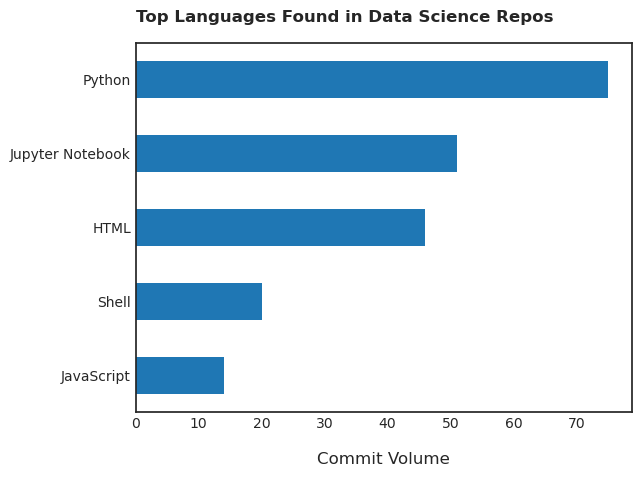

In [22]:
top_5_ds_lang = ds_ai_technologies.limit(5).toPandas()
top_5_ds_lang.sort_values('count').plot('language_name', 'count', kind='barh', legend=False)
plt.ylabel('', labelpad=15, fontsize=12)
plt.xlabel('Commit Volume', labelpad=15, fontsize=12)
plt.title('Top Languages Found in Data Science Repos', fontsize=12, loc='left', pad=15, weight="bold")
plt.show()

In [23]:
ds_ai_technologies.unpersist()

DataFrame[language_name: string, count: bigint]

In [35]:
languages_exploded.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language_name: string (nullable = true)



In [36]:
commits_repo.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- date: date (nullable = true)



In [41]:
repo_lang_joined = commits_repo.join(languages_exploded, on='repo_name', how='inner')
repo_lang_joined.cache()
repo_lang_joined.show(5, truncate=False)

24/11/26 00:32:12 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+------------+----------+-------------+
|repo_name   |date      |language_name|
+------------+----------+-------------+
|0-0-1/cogbot|2017-01-19|Python       |
|0-0-1/cogbot|2017-05-28|Python       |
|0-0-1/cogbot|2017-01-21|Python       |
|0-0-1/cogbot|2017-08-19|Python       |
|0-0-1/cogbot|2017-05-03|Python       |
+------------+----------+-------------+
only showing top 5 rows



In [52]:
ds_ai_projects_date = ds_ai_projects.join(commits_repo.select('repo_name', F.year('date')), on='repo_name', how="inner")
ds_ai_projects_date.cache()
ds_ai_projects_date.show(5, truncate=False)

24/11/26 00:51:35 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+--------------------------------------------+----------+
|repo_name                                   |year(date)|
+--------------------------------------------+----------+
|mdda/pycon.sg-2015_deep-learning            |2015      |
|nightjean/Deep-Learning                     |2017      |
|CforED/Machine-Learning                     |2015      |
|mdda/deep-learning-workshop                 |2017      |
|agile-data-scientists/data-science-manifesto|2011      |
+--------------------------------------------+----------+
only showing top 5 rows



In [90]:
ds_ai_lang_date.unpersist()

DataFrame[repo_name: string, year(date): int, language_name: string]

In [91]:
ds_ai_lang_date = ds_ai_projects_date.join(languages_exploded, on='repo_name', how="inner")
ds_ai_lang_date.show(5, truncate=False)

+------------------------------------+----------+-------------+
|repo_name                           |year(date)|language_name|
+------------------------------------+----------+-------------+
|AhmedHani/FCIS-Machine-Learning-2017|2017      |C++          |
|AhmedHani/FCIS-Machine-Learning-2017|2017      |C++          |
|AhmedHani/FCIS-Machine-Learning-2017|2017      |C++          |
|AhmedHani/FCIS-Machine-Learning-2017|2017      |C++          |
|AhmedHani/FCIS-Machine-Learning-2017|2017      |C++          |
+------------------------------------+----------+-------------+
only showing top 5 rows



In [92]:
ds_ai_technologies_over_time =(
    ds_ai_lang_date.
    withColumnRenamed('year(date)', 'year').
    groupBy('year', 'language_name').
    count().
    orderBy("year", F.desc('count'))
)

In [36]:
path = "gs://msca-bdp-students-bucket/shared_data/sarthakdhanke/ds_ai_technologies_over_time"
# # ds_ai_technologies_over_time.write.parquet(path)

In [6]:
ds_ai_technologies_over_time = spark.read.parquet(path)
ds_ai_technologies_over_time.cache()
ds_ai_technologies_over_time.show(5)

+----+---------------+-----+
|year|  language_name|count|
+----+---------------+-----+
|2016|          CMake|12065|
|2016|Protocol Buffer|12030|
|2016|           LLVM|12030|
|2016|             Go|12030|
|2016|              C|12030|
+----+---------------+-----+
only showing top 5 rows



In [93]:
yearly_counts = ds_ai_technologies_over_time.toPandas()

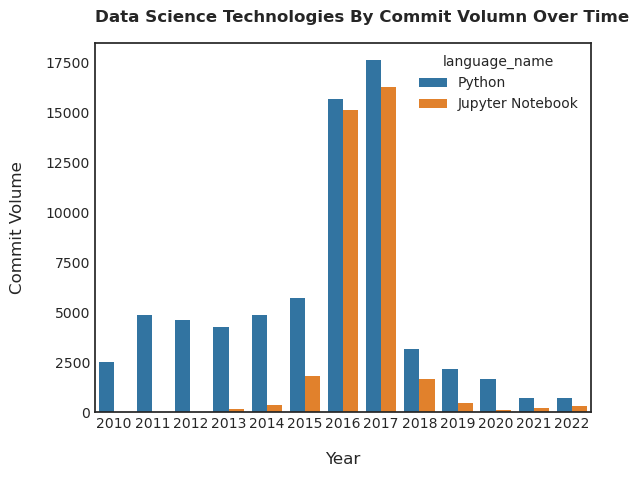

In [94]:
# filter only Python & Jupyter Notebook
sns.barplot(x='year', y='count', 
            hue='language_name', 
            data=yearly_counts[yearly_counts.language_name.isin(['Python', "Jupyter Notebook"])])
plt.xlabel('Year', labelpad=15, fontsize=12)
plt.ylabel('Commit Volume', labelpad=15, fontsize=12)
plt.title('Data Science Technologies By Commit Volumn Over Time', fontsize=12, loc='left', pad=15, weight="bold")
plt.show()

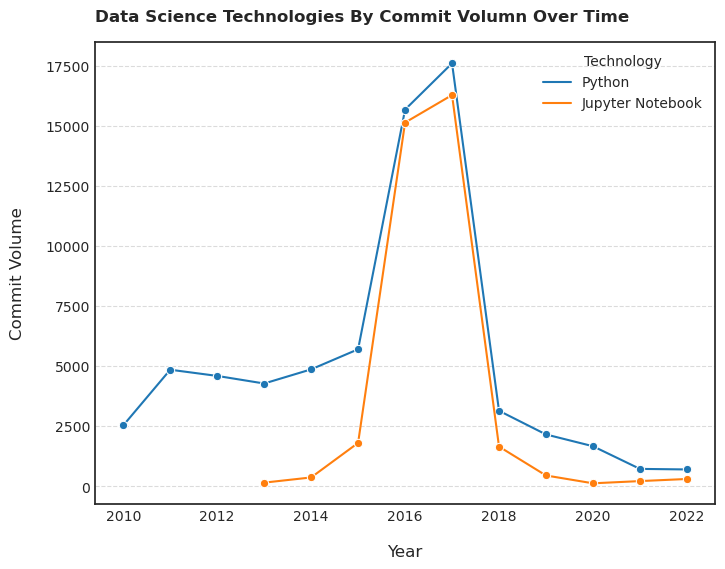

In [102]:
# Filter for top 5 languages (or select specific technologies)
top_languages = ['Python', 'Jupyter Notebook']
trend_data = yearly_counts[yearly_counts["language_name"].isin(top_languages)]

# Plot trends
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=trend_data,
    x="year",
    y="count",
    hue="language_name",
    marker="o",
    palette="tab10"
)
plt.xlabel('Year', labelpad=15, fontsize=12)
plt.ylabel('Commit Volume', labelpad=15, fontsize=12)
plt.title('Data Science Technologies By Commit Volumn Over Time', fontsize=12, loc='left', pad=15, weight="bold")
plt.legend(title="Technology")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### What are the most frequent reasons for committing into GitHub repositories?
### Is this new technology development, bug fix, etc.

In [76]:
commits_message_sample = commits_relevant_filtered.select('message').sample(0.001, False, 1984)

In [77]:
from pyspark.sql import functions as F

# Define function to classify commit messages
def classify_commit_message(message):
    message = message.lower()
    if "fix" in message or "bug" in message or "issue" in message:
        return "Bug Fix"
    elif "add" in message or "feature" in message or "new" in message:
        return "Feature Development"
    elif "docs" in message or "readme" in message or "doc" in message:
        return "Documentation"
    elif "refactor" in message or "cleanup" in message or "optimize" in message:
        return "Refactoring"
    else:
        return "Other"

# Register the function as a UDF
classify_commit_message_udf = F.udf(classify_commit_message)

# Apply the UDF to the commits dataframe
commits_with_classification = commits_message_sample.withColumn(
    "commit_category", classify_commit_message_udf(F.col("message"))
)

# Count frequency of each category
category_counts = commits_with_classification.groupBy("commit_category").count().orderBy("count", ascending=False)

category_counts.show(truncate=False)

+-------------------+------+
|commit_category    |count |
+-------------------+------+
|Other              |142649|
|Feature Development|46467 |
|Bug Fix            |44488 |
|Documentation      |10460 |
|Refactoring        |3942  |
+-------------------+------+



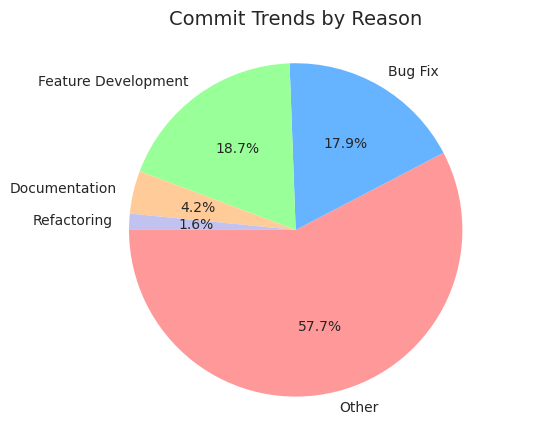

In [72]:
import matplotlib.pyplot as plt

# Data
commit_categories = ['Other', 'Bug Fix', 'Feature Development', 'Documentation', 'Refactoring']
commit_counts = [142990, 44467, 46353, 10313, 3883]

# Create a pie chart
# plt.figure(figsize=(8, 8))
plt.pie(commit_counts, labels=commit_categories, autopct='%1.1f%%', startangle=180, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Commit Trends by Reason', fontsize=14, pad=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

# Show the chart
plt.show()

### Identify the most prolific / influential Committers
### By commit volume
### Visualize the distribution of these commits

In [49]:
prolific_committers = commits_df.groupBy('author.name').count().orderBy('count', ascending=False)
prolific_committers.show(10, truncate=False)

+-----------------------+-------+
|name                   |count  |
+-----------------------+-------+
|shenzhouzd             |1188430|
|dependabot[bot]        |622184 |
|Duane F. King          |597940 |
|Marge Spiderworthy     |495786 |
|Curt Clifton           |384915 |
|dependabot-preview[bot]|373464 |
|James Michael DuPont   |343259 |
|CI Pool Resource       |316075 |
|unknown                |307362 |
|time                   |286934 |
+-----------------------+-------+
only showing top 10 rows



In [50]:
prolific_committers_pd = prolific_committers.limit(20).toPandas()

In [55]:
prolific_committers_pd.sort_values('count')

,name,count
19,Emile B,187684
18,test,189116
17,Renovate Bot,208899
16,conda-forge-coordinator,210085
15,root,230987
14,kfezer,262215
13,aatchison,262278
12,Matthew Weier O'Phinney,265480
11,Jenkins,279799
10,miatribepi,279802


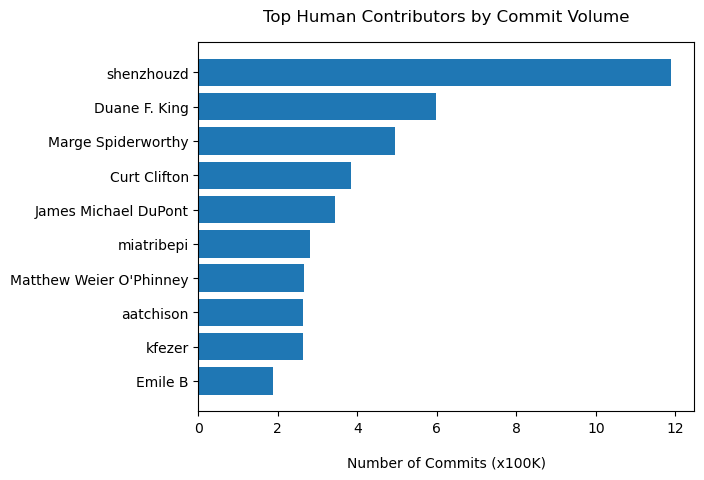

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for human contributors
data = {
    'Contributor': ['Emile B', 'kfezer', 'aatchison', 'Matthew Weier O\'Phinney', 'miatribepi', 
                    'James Michael DuPont', 'Curt Clifton', 'Marge Spiderworthy', 'Duane F. King', 'shenzhouzd'],
    'Commits': [187684, 262215, 262278, 265480, 279802, 343259, 384915, 495786, 597940, 1188430]
}

# Create DataFrame
df_humans = pd.DataFrame(data)



plt.barh(df_humans['Contributor'], df_humans['Commits'] / 100000)
plt.xlabel('Number of Commits (x100K)', labelpad=15)
plt.title('Top Human Contributors by Commit Volume', pad=15)

plt.show()


### How unique are the “subject” and “message” values?
### Are they mostly unique? Or are people usually just copy-pasting the same text?
### You can use LSH to measure uniqueness / similarity
### Visualize “subject” and “message” duplication across all programming languages
### Visualize “subject” and “message” duplication for each of the top 5 programming languages
### Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [3]:
from pyspark.ml.feature import MinHashLSH, CountVectorizer, StopWordsRemover

In [19]:
commits_message_subject_sample = commits_df.select('subject','message').sample(0.00001, False, 1984)

In [20]:
# Cleaning and tokenizing 'subject'
df = commits_message_subject_sample.withColumn("cleaned_words_subject", 
                   F.split(F.regexp_replace(F.col("subject"), "[\p{P}\p{C}]", ""), " "))

# Cleaning and tokenizing 'message'
df = df.withColumn("cleaned_words_message", 
                   F.split(F.regexp_replace(F.col("message"), "[\p{P}\p{C}]", ""), " "))

# Stopword removal
remover = StopWordsRemover(inputCol="cleaned_words_subject", outputCol="filtered_words_subject")
df = remover.transform(df)

remover = StopWordsRemover(inputCol="cleaned_words_message", outputCol="filtered_words_message")
df = remover.transform(df)

In [21]:
# Combine subject and message words
df_combined = df.withColumn(
    "combined_filtered_words", 
    F.concat(F.col("filtered_words_subject"), F.col("filtered_words_message"))
)

# Train a single CountVectorizer model
vectorizer = CountVectorizer(
    inputCol="combined_filtered_words", 
    outputCol="combined_features", 
    minDF=1.0
)
vectorizer_model = vectorizer.fit(df_combined)

In [22]:
# Transform for subject
df_subject_vectorized = vectorizer_model.transform(
    df.withColumnRenamed("filtered_words_subject", "combined_filtered_words")
).select("subject", F.col("combined_features").alias("subject_features")).withColumn("id", F.monotonically_increasing_id())

# Transform for message
df_message_vectorized = vectorizer_model.transform(
    df.withColumnRenamed("filtered_words_message", "combined_filtered_words")
).select("message", F.col("combined_features").alias("message_features")).withColumn("id", F.monotonically_increasing_id())

In [23]:
# Combine the two DataFrames on the "id" column
df_combined = (
    df_subject_vectorized
    .join(df_message_vectorized, on="id", how="inner")
    .select("id", "subject", "message", "subject_features", "message_features")
)

A simpler Jaccard similarity function was defined because the one provided by pyspark was having performance issues and gave inconsistent answers

In [24]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F

# Step 1: Combine "subject_features" and "message_features" into the same DataFrame
# df_combined = df_transformed.select("subject_features", "message_features", "subject", "message")

# Step 2: Define a UDF to compute Jaccard similarity
def jaccard_similarity(v1, v2):
    set1 = set(v1.indices)
    set2 = set(v2.indices)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return float(intersection) / float(union)

jaccard_udf = F.udf(jaccard_similarity)

# Step 3: Apply Jaccard similarity calculation for each record
df_similarity = (
    df_combined.withColumn(
        "jaccard_similarity",
        jaccard_udf(F.col("subject_features"), F.col("message_features"))
    )
)

# Step 4: Show the results


In [25]:
threshold = 0.7
dups = (
    df_similarity.
    withColumn(
        'jaccard_distance', 
        1 - F.col('jaccard_similarity')
    ).
    filter(F.col('jaccard_distance') < threshold).
    count()
)

In [26]:
uniques = df_similarity.count() - dups

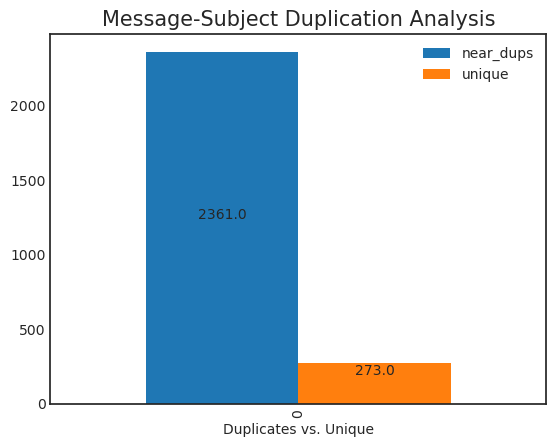

In [27]:
import pandas as pd
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Message-Subject Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

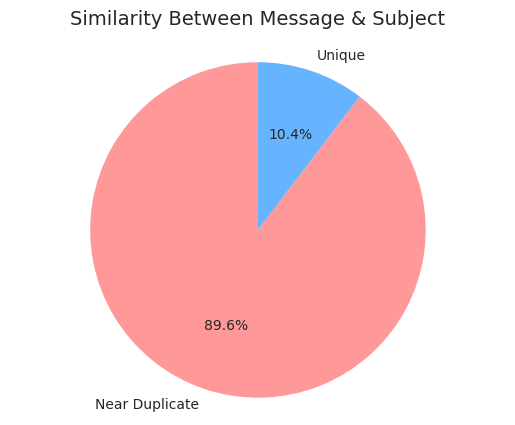

In [30]:
commit_categories = ['Near Duplicate', 'Unique']
commit_counts = [dups, uniques]

# Create a pie chart
# plt.figure(figsize=(8, 8))
plt.pie(commit_counts, labels=commit_categories, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Similarity Between Message & Subject', fontsize=14, pad=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

# Show the chart
plt.show()